In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
sns.set_theme(style='whitegrid')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [83]:
train_path = '/Users/tristanosborn/Downloads/histopathologic-cancer-detection/train'
test_path = '/Users/tristanosborn/Downloads/histopathologic-cancer-detection/test'
labels = pd.read_csv('/Users/tristanosborn/Downloads/histopathologic-cancer-detection/train_labels.csv')

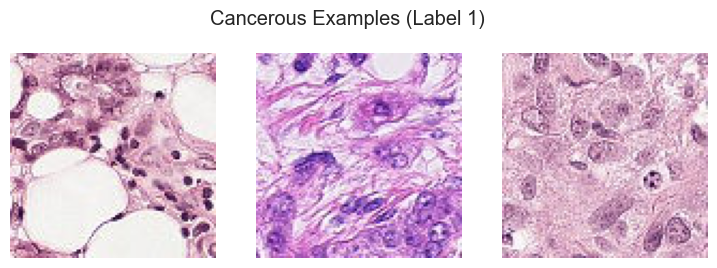

In [84]:
cancer_images = labels[labels.label == 1].sample(3); plt.figure(figsize=(9, 3)); 
for i, img_id in enumerate(cancer_images['id']): plt.subplot(1, 3, i+1); plt.imshow(Image.open(os.path.join(train_path, img_id + '.tif'))); plt.axis('off'); 
plt.suptitle("Cancerous Examples (Label 1)");

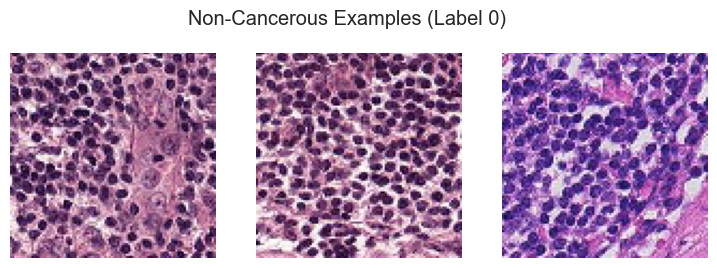

In [85]:
non_cancer_images = labels[labels.label == 0].sample(3); plt.figure(figsize=(9, 3)); 
for i, img_id in enumerate(non_cancer_images['id']): plt.subplot(1, 3, i+1); plt.imshow(Image.open(os.path.join(train_path, img_id + '.tif'))); plt.axis('off'); 
plt.suptitle("Non-Cancerous Examples (Label 0)"); plt.show()

### EDA

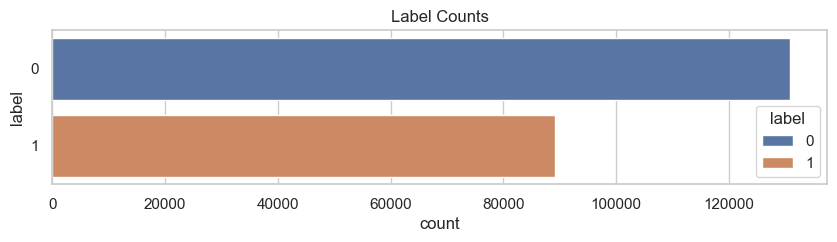

In [86]:
#label counts
plt.figure(figsize=(10, 2))
sns.countplot(y='label', data=labels, hue='label')
plt.title("Label Counts");

In [87]:
print(len(labels[labels.label == 1]))

89117


In [88]:
print(len(labels[labels.label == 0]))

130908


There are 89117 records labeled as having cancer and 130908 as not having cancer.

### Preprocessing

In [73]:
#preprocessing
labels['id'] = labels['id'] + '.tif'
labels['label'] = labels['label'].astype(str)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    labels, train_path, x_col='id', y_col='label',
    target_size=(60, 60), class_mode='binary',
    batch_size=32, subset='training'
)

val_gen = datagen.flow_from_dataframe(
    labels, train_path, x_col='id', y_col='label',
    target_size=(60, 60), class_mode='binary',
    batch_size=32, subset='validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### Model

The model I'm using has two convolutional layers, followed by pooling to reduce image size, then flattens the output and passes it through a dense layer. A final sigmoid layer outputs a probability for binary classification. Dropout helps prevent overfitting, and the model is trained using the Adam optimizer and early stopping.

In [74]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(60,60,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop])

Epoch 1/10


/Users/tristanosborn/cancer-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/tristanosborn/cancer-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 121s 22ms/step - accuracy: 0.7727 - loss: 0.4886 - val_accuracy: 0.8217 - val_loss: 0.4085
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 124s 22ms/step - accuracy: 0.8331 - loss: 0.3844 - val_accuracy: 0.8351 - val_loss: 0.3790
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.8459 - loss: 0.3560 - val_accuracy: 0.8541 - val_loss: 0.3419
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 127s 23ms/step - accuracy: 0.8529 - loss: 0.3396 - val_accuracy: 0.8592 - val_loss: 0.3284
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 128s 23ms/step - accuracy: 0.8582 - loss: 0.3301 - val_accuracy: 0.8639 - val_loss: 0.3177
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 129s 23ms/step - accuracy: 0.8639 - loss: 0.3194 - val_accuracy: 0.8610 - val_loss: 0.3239
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 128s 23ms/step - accuracy: 0.8669 - loss: 0.3123 - val_accuracy: 0.8618 - val_loss: 0.3195
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 125s 23ms/step - accuracy: 0.8704 - lo

### Metrics

Text(0.5, 1.0, 'Accuracy by Epoch')

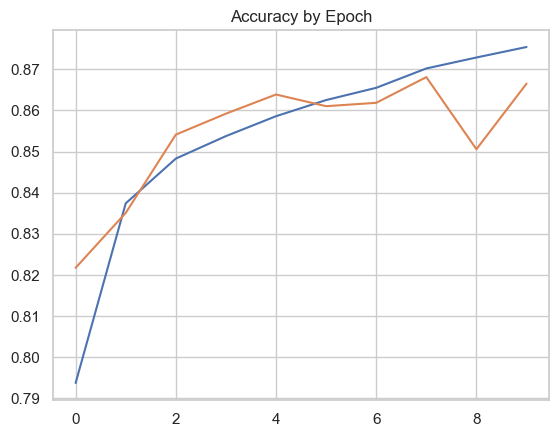

In [ ]:
#accuracy plot
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_' + "accuracy"])
plt.title(f'{"accuracy".title()} by Epoch')

In [78]:
#test data preds
size = (60, 60)
test_pics = os.listdir(test_path)
test_df = pd.DataFrame({'id': test_pics})

test_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, test_path, x_col='id', y_col=None,
    target_size=size, batch_size=1, class_mode=None, shuffle=False
)

preds = cnn.predict(test_gen, steps=len(test_gen), verbose=1)
test_df['label'] = (preds > 0.5).astype(int)
test_df['id'] = test_df['id'].str.replace('.tif', '')
test_df.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
57458/57458 ━━━━━━━━━━━━━━━━━━━━ 32s 556us/step
